In [604]:
import numpy as np
import numpy.random as rd
import pandas as pd
import os
import sys
import datetime
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(style="whitegrid", palette="muted", color_codes=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [605]:
cwd = os.getcwd()

dt = datetime.datetime.now()
tday = "{0:%Y%m%d%H%M}".format(dt)

experiment_id = "particle_filter" + tday
os.mkdir(experiment_id)
os.mkdir(experiment_id + "\\CKPT")
os.mkdir(experiment_id + "\\DATA")
save_stats_path = cwd + "\\" + experiment_id +"\\STATS\\"
save_data_path = cwd + "\\" + experiment_id +"\\DATA\\"

In [606]:
class NoisyDataProcesser():
    def __init__(self, alpha_2, sigma_2, mu,length):
        self.alpha_2 = alpha_2
        self.sigma_2 = sigma_2
        self.mu = mu
        self.length = length
    def process(self, path):
        x = []
        y = []
        list_sigma_2 = []
        list_mu = []
        x.append(rd.normal(0, np.sqrt(self.alpha_2)))
        y.append(x[0] + rd.normal(self.mu, np.sqrt(self.sigma_2)))
        list_sigma_2.append(self.sigma_2)
        list_mu.append(self.mu)
        for t in range(self.length):
            if t > self.length/2:
                self.mu = -5
            # elif t > self.length * 2.0 /3.0:
            #     self.mu = -8
            # # self.mu += 0.02
            x.append(x[t] + rd.normal(0, np.sqrt(self.alpha_2)))
            y.append(x[t+1] + rd.normal(self.mu, np.sqrt(self.sigma_2)))
            list_sigma_2.append(self.sigma_2)
            list_mu.append(self.mu)
        x = np.array(x)
        y = np.array(y)
        list_sigma_2 = np.array(list_sigma_2)
        list_mu = np.array(list_mu)
        np.savetxt(path + "noisy_obs.txt", y)
        np.savetxt(path + "truth_obs.txt", x)
        np.savetxt(path + "sigma_2.txt", list_sigma_2)
        np.savetxt(path + "mu.txt", list_mu)

In [607]:
# !ls data

In [608]:
# # data url: http://daweb.ism.ac.jp/yosoku/

# # 直接読み込む場合 
# df = pd.read_csv("http://daweb.ism.ac.jp/yosoku/materials/PF-example-data.txt", header=None)

# # 別途ダウンロードしてから取り込む場合
# #df = pd.read_csv("./data/PF-example-data.txt", header=-1)

# df.columns = ["data"]

In [609]:
class ParticleFilter(object):
    def __init__(self, y, x_truth, n_particle, sigma_2, alpha_2, mu):
        self.y = y
        self.x_truth = x_truth
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.mu = mu
        self.log_likelihood = -np.inf
    
    def norm_likelihood(self, y, x, s2, mu):
        l = (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-(x+mu))**2/(2*s2))
        if np.isnan(l):
            print("Nan!! y:{},x:{},s2:{}, mu:{}".format(y,x,s2,mu))
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-(x+mu))**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                # if for all i w_cumsum[i] >= u then:
                return 0
            # if there exsist i such that w_cumsum[i] < u then:
            k = np.max(idx[w_cumsum < u])
            return k+1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k


    
    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle, 3))
        x_resampled = np.zeros((T+1, self.n_particle, 3))
        
        # 潜在変数の初期値
        initial_x = 20 * rd.rand(self.n_particle) - 10
        # initial_x = rd.normal(0, 1, size=self.n_particle)

        # initial_sigma_2 = rd.normal(0.5, 0, size=self.n_particle)
        # initial_mu = rd.normal(self.mu, 0, size=self.n_particle)

        # initial_mu = rd.normal(3, 0, size=self.n_particle)

        # initial_sigma_2 = rd.rand(self.n_particle) + sys.float_info.min
        # initial_mu = 20 * rd.rand(self.n_particle) - 10

        initial_sigma_2 = rd.rand(self.n_particle) + sys.float_info.min
        initial_mu = rd.normal(self.mu, 0, size=self.n_particle)

        x_resampled[0][:,0] = initial_x
        x_resampled[0][:,1] = initial_sigma_2
        x_resampled[0][:,2] = initial_mu
        x[0][:,0] = initial_x
        x[0][:,1] = initial_sigma_2
        x[0][:,2] = initial_mu

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2)) # System Noise
                x[t+1, i, 0] = x_resampled[t, i, 0] + v # システムノイズの付加
                x[t+1, i, 1] = x_resampled[t, i, 1] # システムノイズの付加
                x[t+1, i, 2] = x_resampled[t, i, 2]
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i, 0], x[t+1, i, 1],x[t+1, i, 2]) # y[t]に対する各粒子の尤度
#                 print("w[t, i]:{}".format(w[t, i]))
            w_normed[t] = w[t]/np.sum(w[t]) # 規格化
#             print("t:{},w[t]:{}, np.sum(w[t]):{}, w_normed:{}".format(t, np.sort(w[t])[0:10], np.sum(w[t]),np.sort(w_normed[t])[0:10] ))
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t+1] = x[t+1, k]

            # ReResampling
            if t % 10 == 0:
                K_inherit = int(self.n_particle*0.9)
                K_new = self.n_particle - K_inherit
                if K_inherit != self.n_particle:
                    w_resampled = w_normed[t][k]


                    unsorted_max_indices = np.argpartition(-w_resampled, K_inherit)[:K_inherit]
                    x_inherit = x[t+1, unsorted_max_indices]

                    x_new = np.zeros((K_new, 3))
                    new_state_x = 20 * rd.rand(K_new) - 10
                    # new_state_x = rd.normal(0, 1, size=K_new)
                    new_sigma_2 = rd.rand(K_new) + sys.float_info.min
                    new_mu = (10 - (-10)) * rd.rand(K_new) - 10
                    x_new[:,0] = new_state_x
                    x_new[:,1] = new_sigma_2
                    x_new[:,2] = new_mu
                    x_resampled[t+1] = np.concatenate([x_new,x_inherit])
            print("likelihood{}\n".format(l[t]), end="")
            
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        print(self.w_normed)
        return np.diag(np.dot(self.w_normed, self.x[1:,:,0].T))
        
    def draw_graph_1(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, color="b", label="observation")
        plt.plot(self.get_filtered_value(), color="g", label="mean_of_state_particles")
        plt.plot(self.x_truth, color="y",label="true_value")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,0], color="r", s=2, alpha=0.1, label="state_particle")
        
        plt.xlabel("step")
        plt.ylabel("x")
#         plt.legend()
        plt.title("How particle filter works , state : sigma^2={0}, mu={1},alpha^2={2}".format(self.sigma_2, self.mu ,self.alpha_2))
        plt.savefig(save_data_path + "state_particle.png", facecolor="white")
    def draw_graph_2(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, color="b", label="observation")
        plt.plot(self.get_filtered_value(), color="g", label="mean_of_state_particles")
        plt.plot(self.x_truth, color="y",label="true_value")
        plt.xlabel("step")
        plt.ylabel("x")
        plt.legend()
        plt.title("How particle filter works , state : sigma^2={0}, mu={1},alpha^2={2}".format(self.sigma_2, self.mu ,self.alpha_2))
        plt.savefig(save_data_path + "state_estimate.png", facecolor="white")
    def draw_graph_sigma_2(self, sigma_2_tru):
        
        self.sigma_2_tru = sigma_2_tru
        
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,1], color="r", s=2, alpha=0.1, label="parameter_particle")
        plt.plot(range(T), self.sigma_2_tru, color="b", label="sigma_2_tru")
        plt.xlabel("step")
        plt.ylabel("sigma_2")
#         plt.legend()
        plt.title("How particle filter works , parameter: sigma^2={0}, alpha^2={1}".format(self.sigma_2, self.alpha_2))
        plt.savefig(save_data_path + "sigma_particle.png", facecolor="white")
    def draw_graph_mu(self, mu_tru):
        
        self.mu_tru = mu_tru
        
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,2], color="r", s=2, alpha=0.1, label="parameter_particle")
        plt.plot(range(T), self.mu_tru, color="b", label="sigma_2_tru")
        plt.xlabel("step")
        plt.ylabel("mu_2")
#         plt.legend()
        plt.title("How particle filter works , parameter: sigma^2={0}, alpha^2={1}".format(self.sigma_2, self.alpha_2))
        plt.savefig(save_data_path + "mu_particle.png", facecolor="white")

### パーティクルフィルターによるフィルタリング

In [610]:
# ハイパーパラメーター
params = {}
a = -2
b = -1

n_particle = 10**3
# sigma_2 = 2**a
# alpha_2 = 10**b
# mu = -5
sigma_2 = 0.5
alpha_2 = 10**b
mu = 5
length = 2000


params["a"] = a
params["b"] = b
params["n_particle"] = n_particle
params["sigma_2"] = sigma_2
params["alpha_2"] = alpha_2
params["mu"] = mu
params["length"] = length
import json
with open(save_data_path + "params.json", "w") as file:
    json.dump(params, file)

In [611]:
dataprocesser = NoisyDataProcesser(alpha_2, sigma_2, mu, length)
dataprocesser.process(save_data_path)
noisy_obs = pd.read_csv(save_data_path + "noisy_obs.txt",header=None)
truth_obs = pd.read_csv(save_data_path + "truth_obs.txt",header=None) 
noisy_obs.columns = ["data"]
truth_obs.columns = ["data"]
sigma_2_tru = pd.read_csv(save_data_path + "sigma_2.txt",header=None)
mu_tru = pd.read_csv(save_data_path + "mu.txt",header=None) 
sigma_2_tru.columns = ["data"]
mu_tru.columns = ["data"]

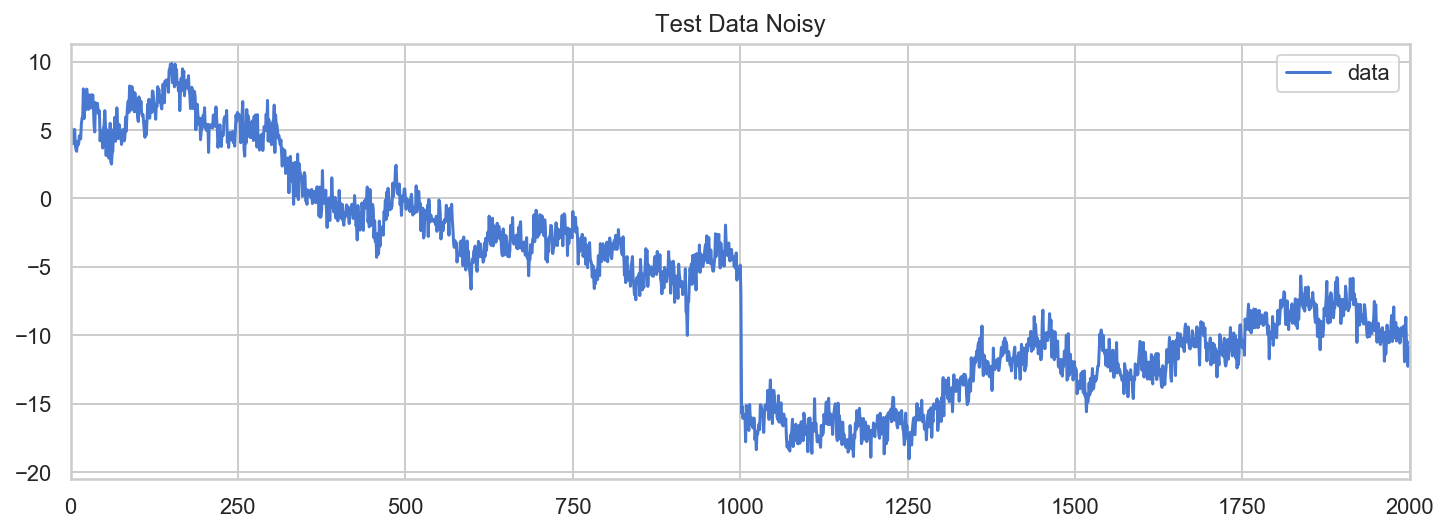

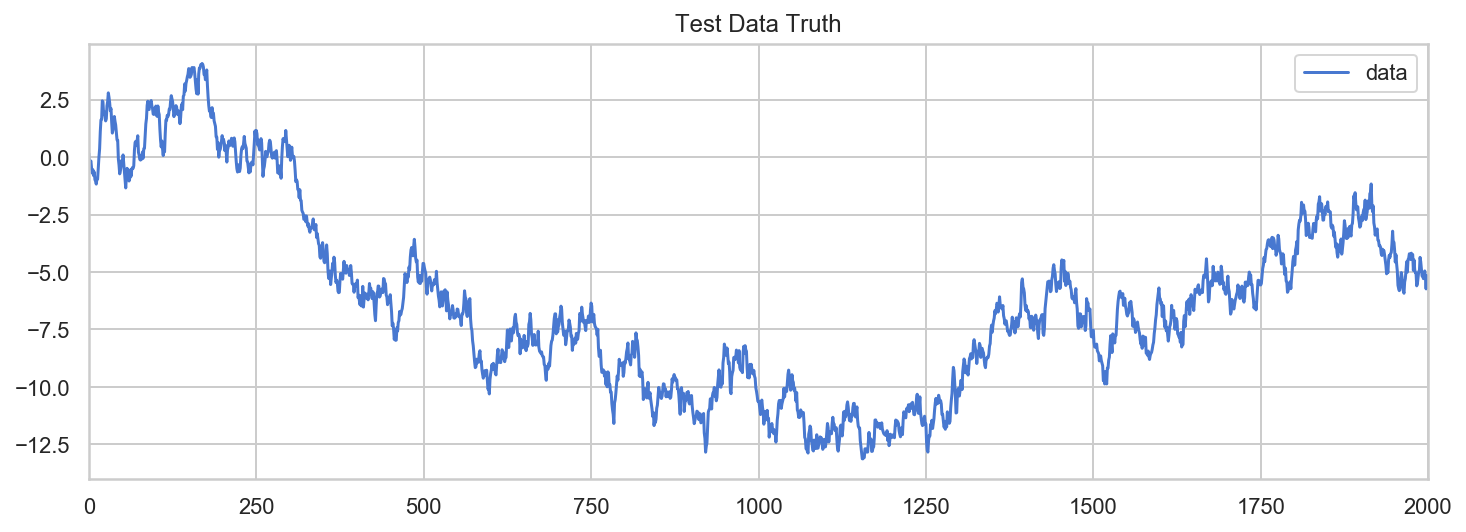

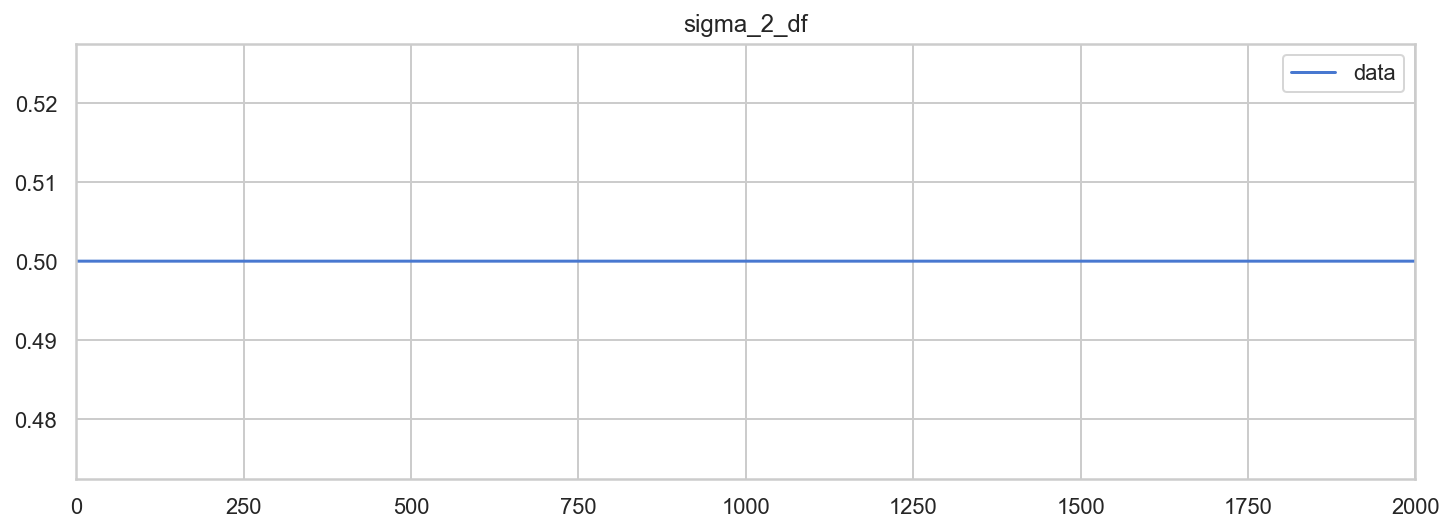

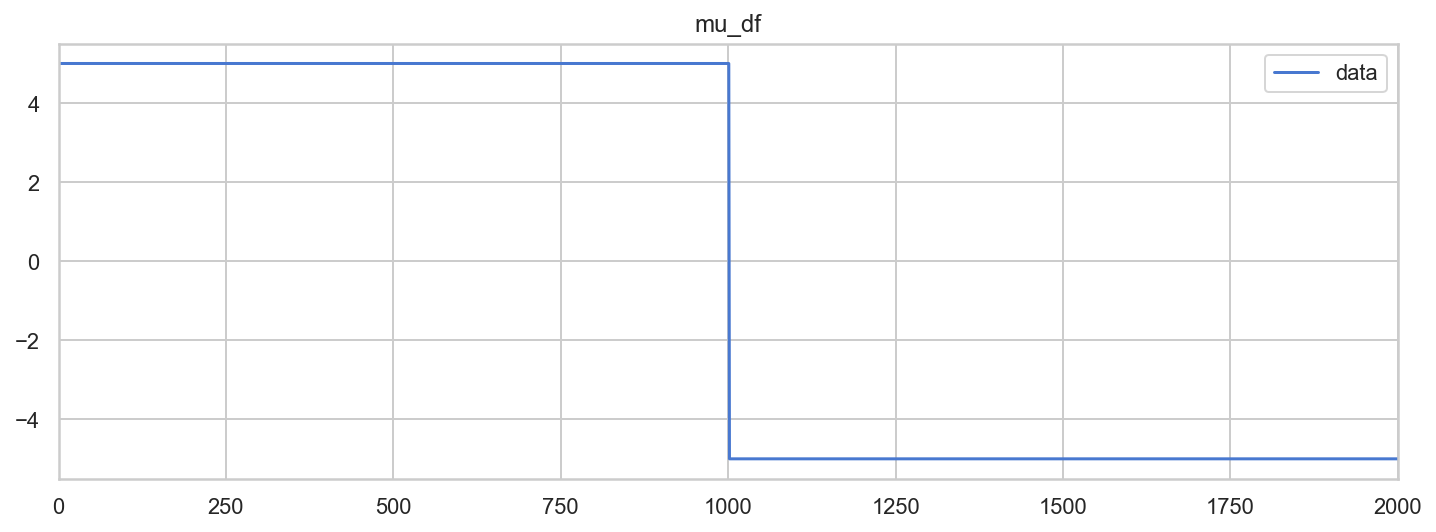

In [612]:
noisy_obs.plot(figsize=(12,4))
plt.title("Test Data Noisy")
plt.savefig(save_data_path + "noisy_obs.png", facecolor="white")

truth_obs.plot(figsize=(12,4))
plt.title("Test Data Truth")
plt.savefig(save_data_path + "truth_obs.png", facecolor="white")

sigma_2_tru.plot(figsize=(12,4))
plt.title("sigma_2_df")
plt.savefig(save_data_path + "sigma_2_df.png", facecolor="white")

mu_tru.plot(figsize=(12,4))
plt.title("mu_df")
plt.savefig(save_data_path + "mu_df.png", facecolor="white")

In [613]:
pf = ParticleFilter(noisy_obs.data.values, truth_obs.data.values, n_particle, sigma_2, alpha_2,mu)

In [614]:
pf.simulate()

ng... t=1601likelihood6.146696211916128
 calculating... t=1602likelihood5.208447966627717
 calculating... t=1603likelihood4.049592849815892
 calculating... t=1604likelihood6.04446596369765
 calculating... t=1605likelihood5.92613376532718
 calculating... t=1606likelihood6.0892939298570905
 calculating... t=1607likelihood5.4630809660446955
 calculating... t=1608likelihood5.175119733572132
 calculating... t=1609likelihood6.153573418057668
 calculating... t=1610likelihood5.99822179015605
 calculating... t=1611likelihood5.936142900790106
 calculating... t=1612likelihood5.763650814882549
 calculating... t=1613likelihood6.117386311698712
 calculating... t=1614likelihood4.830281040867213
 calculating... t=1615likelihood5.744603289879643
 calculating... t=1616likelihood5.513174104248742
 calculating... t=1617likelihood4.967562009255093
 calculating... t=1618likelihood5.897434000220095
 calculating... t=1619likelihood5.951254117708976
 calculating... t=1620likelihood5.607239020749182
 calculatin

[[6.25679290e-023 2.48143154e-145 9.28548187e-019 ... 6.47149651e-004
  9.25470713e-005 6.26926544e-039]
 [6.26781635e-003 2.29201759e-004 2.57544162e-005 ... 5.81001894e-006
  1.89467581e-006 1.05847425e-003]
 [4.58655995e-004 7.10643131e-004 8.76554669e-004 ... 6.51204046e-004
  5.33143909e-004 2.42943067e-003]
 ...
 [2.03636263e-004 4.55652249e-004 5.68357113e-004 ... 6.14746125e-004
  1.34149281e-003 1.56792503e-003]
 [7.59129268e-004 2.78753043e-004 1.58913081e-003 ... 1.03094889e-003
  6.61392902e-004 1.71328659e-003]
 [9.87068427e-004 1.06085051e-003 8.60593412e-004 ... 1.04623847e-003
  1.49077547e-003 5.77661270e-004]]


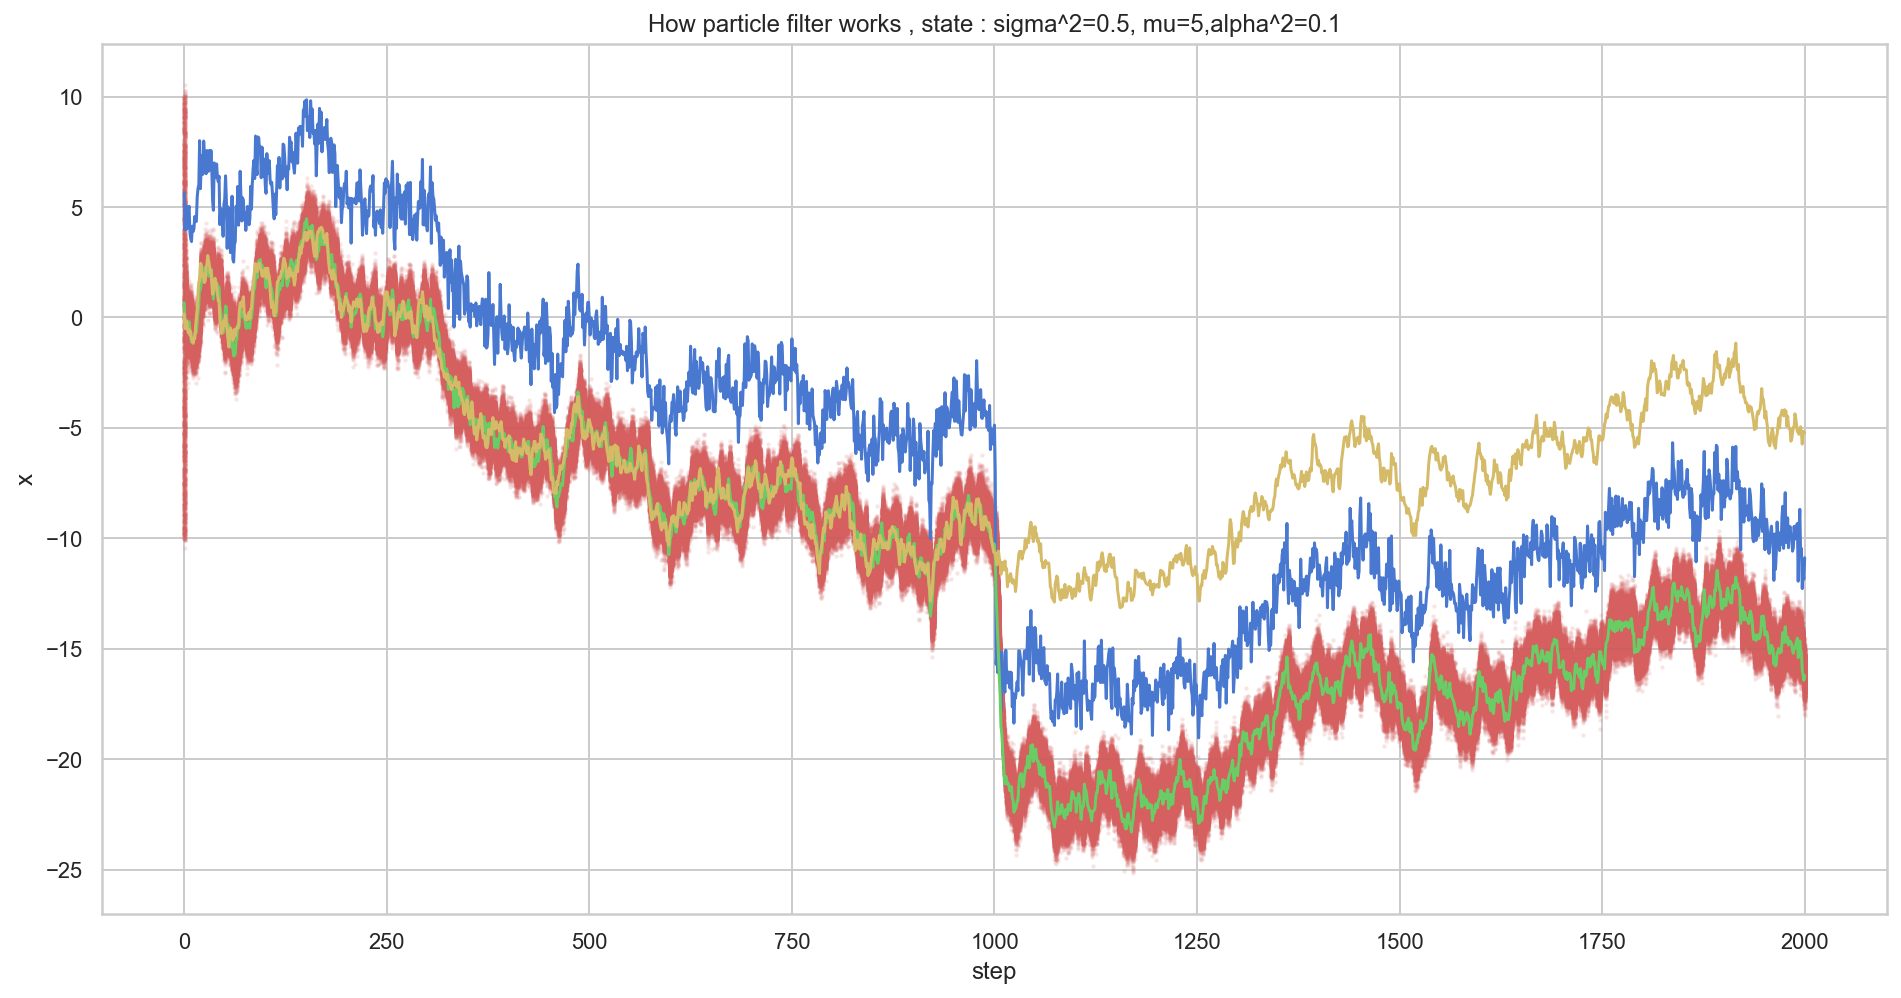

In [615]:
pf.draw_graph_1()

[[6.25679290e-023 2.48143154e-145 9.28548187e-019 ... 6.47149651e-004
  9.25470713e-005 6.26926544e-039]
 [6.26781635e-003 2.29201759e-004 2.57544162e-005 ... 5.81001894e-006
  1.89467581e-006 1.05847425e-003]
 [4.58655995e-004 7.10643131e-004 8.76554669e-004 ... 6.51204046e-004
  5.33143909e-004 2.42943067e-003]
 ...
 [2.03636263e-004 4.55652249e-004 5.68357113e-004 ... 6.14746125e-004
  1.34149281e-003 1.56792503e-003]
 [7.59129268e-004 2.78753043e-004 1.58913081e-003 ... 1.03094889e-003
  6.61392902e-004 1.71328659e-003]
 [9.87068427e-004 1.06085051e-003 8.60593412e-004 ... 1.04623847e-003
  1.49077547e-003 5.77661270e-004]]


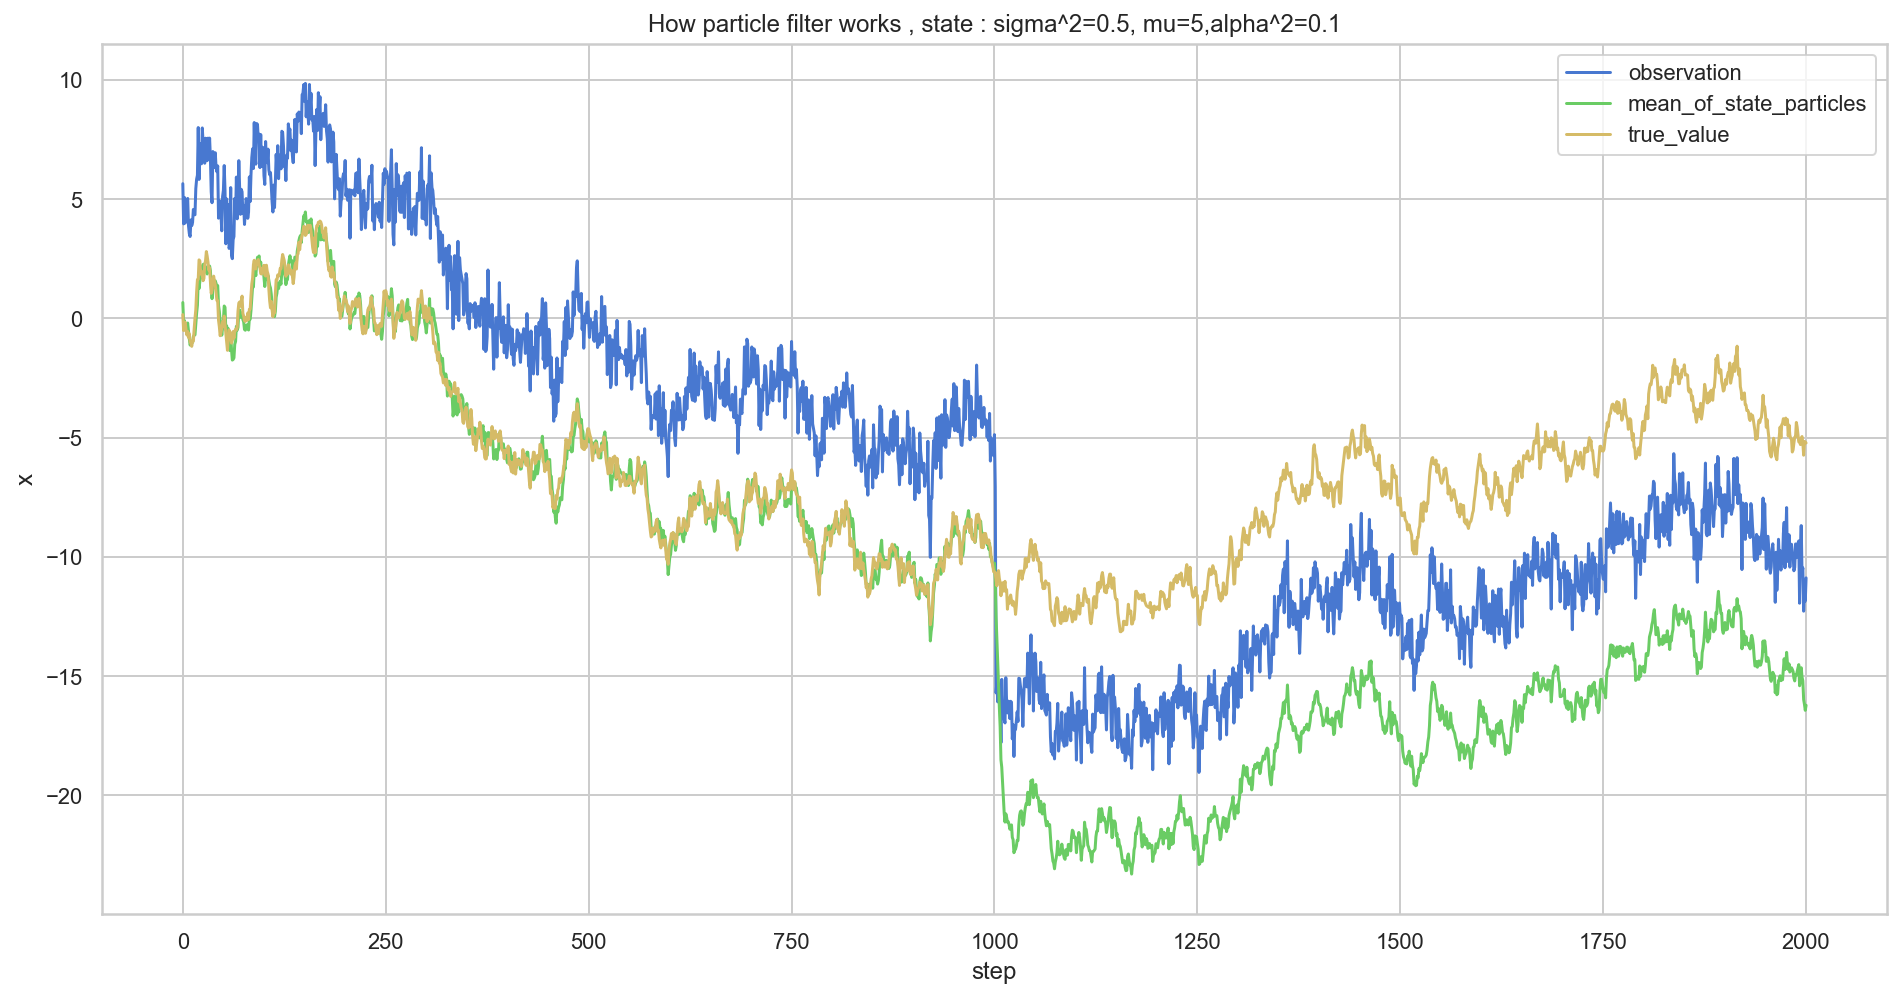

In [616]:
pf.draw_graph_2()

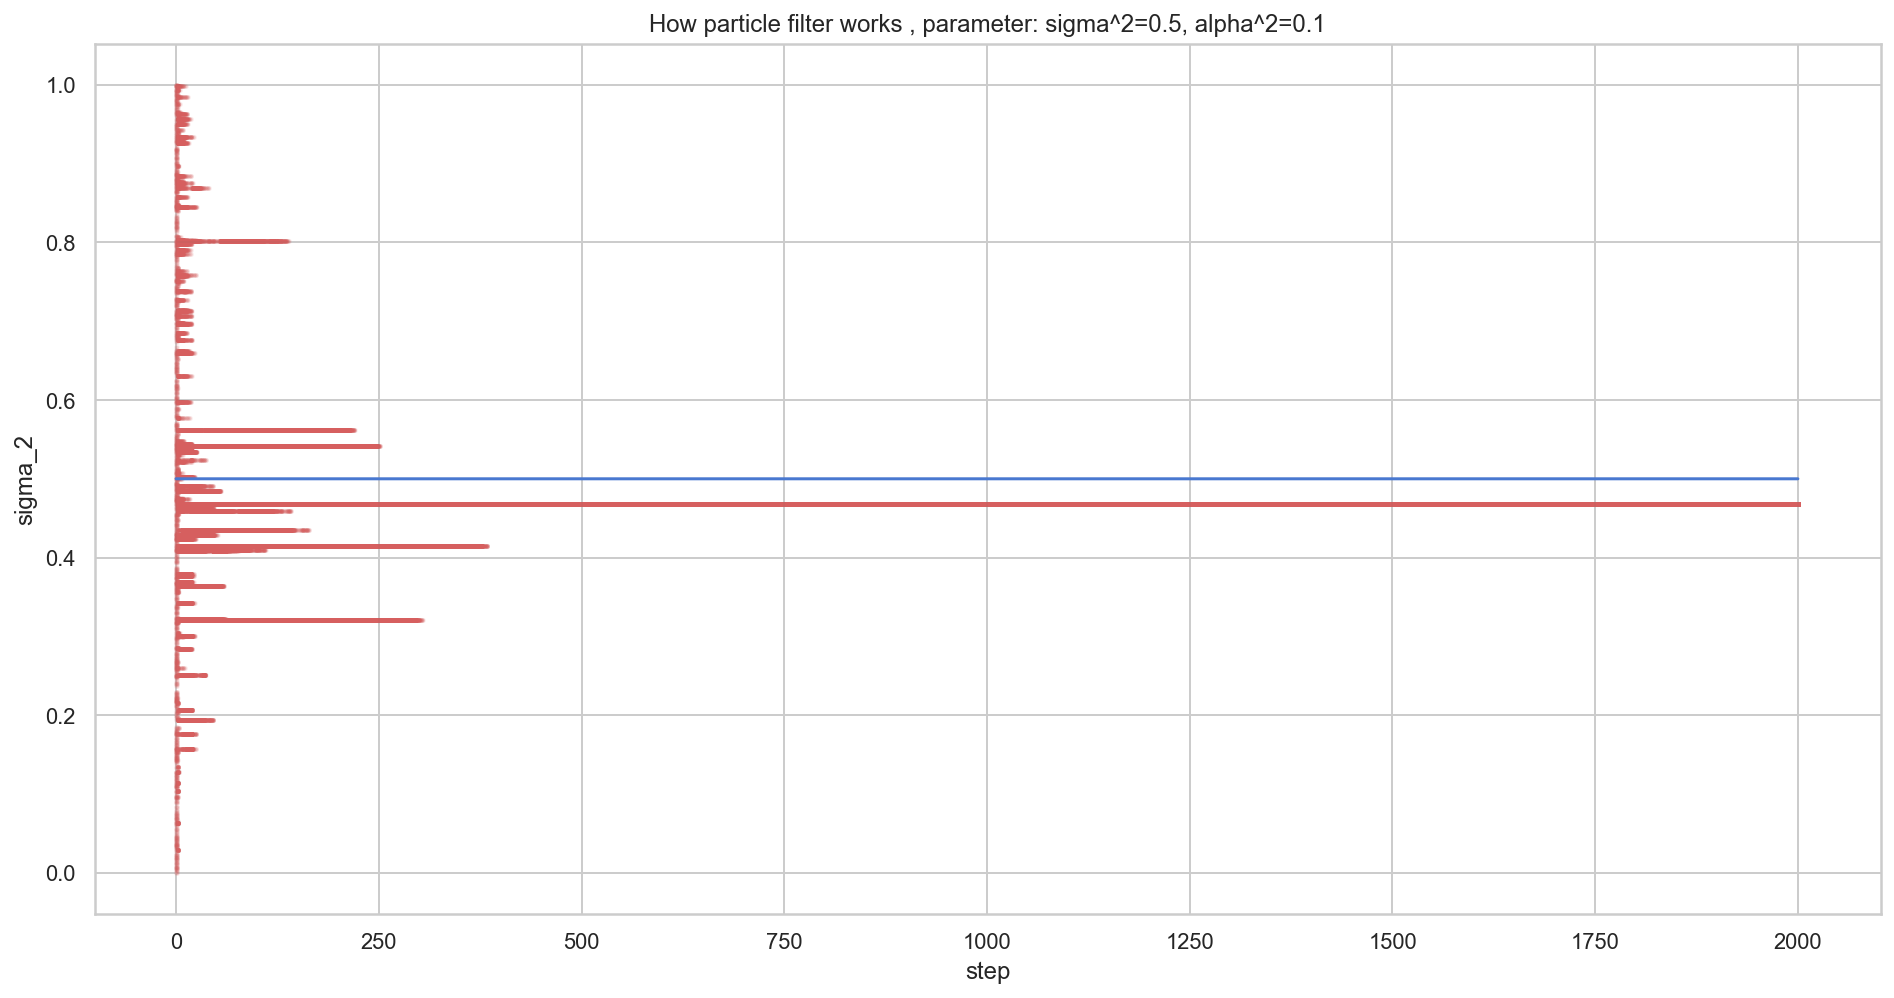

In [617]:
pf.draw_graph_sigma_2(sigma_2_tru)

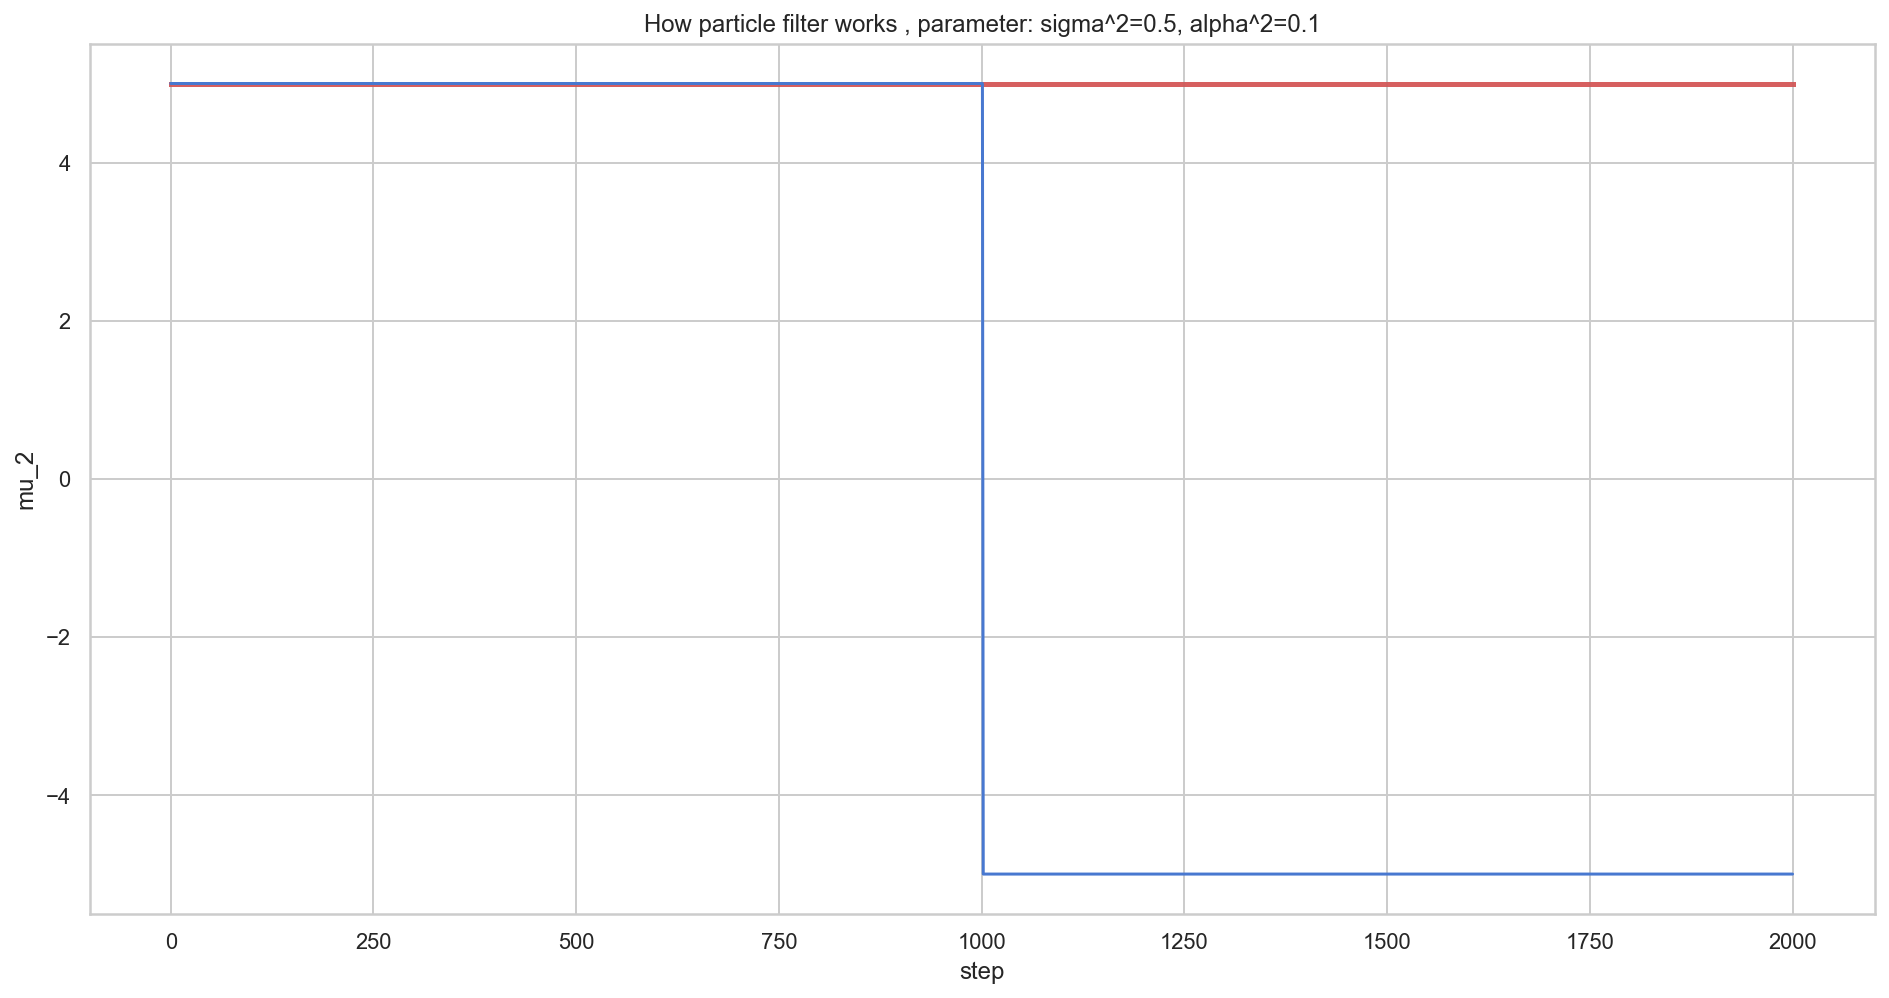

In [618]:
pf.draw_graph_mu(mu_tru)

### カルマンフィルターと見比べる

In [16]:
# Unobserved Components Modeling (via Kalman Filter)の実行
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(df.data.values, 'local level')
res_ll = mod_ll.fit()

print(res_ll.summary())

# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components(legend_loc="upper left", figsize=(12,8))
plt.tight_layout()

NameError: name 'df' is not defined

In [ ]:
T = len(pf.y)

plt.figure(figsize=(16,8))
plt.plot(range(T), pf.y, label="observations")

plt.plot(res_ll.filtered_state.reshape(res_ll.filtered_state.shape[1]), "purple", lw=3, label="UCM filtered")
plt.plot(pf.get_filtered_value(), "g" ,label="filterd with particle")
for t in range(T):
    plt.scatter(np.ones(pf.n_particle)*t, pf.x[t], color="r", s=2, alpha=0.1)
plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(pf.sigma_2, 
                                                                    pf.alpha_2, 
                                                                    pf.log_likelihood))
plt.legend(loc="best")
plt.show()

### ハイパーパラメータGrid Search

In [ ]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)

In [ ]:
idx = np.argmax(likelihood_list)
print("argmax idx:", idx)

print("likelihood={}, a:{}, b={}".format(likelihood_list[idx], a_list[idx], b_list[idx]))

In [ ]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)